In [1]:
from gnn_tracking_hpo.trainable import GCTrainable
from gnn_tracking_hpo.restore import restore_model

In [2]:

ml = restore_model(GCTrainable, tune_dir="gc-hinge-sq-sq-cells", run_hash="7dce6aff")

[13:20:31 HPO] INFO: Initializing pre-trained model
[13:20:31 HPO] DEBUG: Loading config from /home/kl5675/ray_results/gc-hinge-sq-sq-cells/GCTrainable_7dce6aff_24_val_batch_size=1,adam_amsgrad=False,adam_beta1=0.9000,adam_beta2=0.9990,adam_eps=0.0000,adam_weight_decay=_2023-06-08_13-32-02/params.json
[13:20:31 HPO] INFO: I'm running on a node with job ID=48415345
[13:20:31 HPO] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[13:20:31 HPO] INFO: The ID of my dispatcher is 0
[13:20:31 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[13:20:31 HPO] DEBUG: Got config
┌───────────────────────────────┬──────────────────────────────────────────┐
│ _no_data                      │ True                                     │
│ _val_batch_size               │ 1                                        │
│ adam_amsgrad                  │ False                                    │
│ adam_beta1     

In [3]:
from gnn_tracking_hpo.trainable import GCWithECTrainable

ec = restore_model(GCWithECTrainable, run_hash="ddff435e", tune_dir="ds-ef-7dce6aff")

[13:20:33 HPO] INFO: Initializing pre-trained model
[13:20:33 HPO] DEBUG: Loading config from /home/kl5675/ray_results/ds-ef-7dce6aff/GCWithECTrainable_ddff435e_1_val_batch_size=1,adam_amsgrad=False,adam_beta1=0.9000,adam_beta2=0.9990,adam_eps=0.0000,adam_weight_d_2023-06-10_16-10-21/params.json
[13:20:33 HPO] INFO: I'm running on a node with job ID=48415345
[13:20:33 HPO] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[13:20:33 HPO] INFO: The ID of my dispatcher is 0
[13:20:33 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[13:20:33 HPO] DEBUG: Got config
┌────────────────────────────────────┬──────────────────────────────────────────┐
│ _no_data                           │ True                                     │
│ _val_batch_size                    │ 1                                        │
│ adam_amsgrad                       │ False                                    │
│ a

In [4]:
from gnn_tracking.utils.loading import TrackingDataset

val_ds = TrackingDataset("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9", stop=5)

[13:20:33] INFO: DataLoader will load 5 graphs (out of 1000 available).
[13:20:33] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29004_s0.pt


In [5]:
from gnn_tracking.models.graph_construction import MLGraphConstruction

gc = MLGraphConstruction(ml=ml, max_radius=0.8, max_num_neighbors=64, use_embedding_features=True, build_edge_features=True)

In [6]:
graph = gc(val_ds[0].to("cuda"))

In [30]:
graphs = [gc(d.to("cuda")) for d in val_ds]

In [13]:
import numpy as np
from gnn_tracking.analysis.edge_classification import get_all_ec_stats
import pandas as pd
from typing import Sequence
from torch_geometric.data import DataLoader

import torch


def collect_all_ec_stats(
    model: torch.nn.Module,
    data_loader: DataLoader,
    thresholds: Sequence[float],
    n_batches: int | None = None,
    max_workers=6,
    pt_thld=0.9,
) -> pd.DataFrame:
    """Collect edge classification statistics for a model and a data loader, basically
    mapping `get_all_ec_stats` over the data loader with multiprocessing.

    Args:
        model: Edge classifier model
        data_loader: Data loader
        thresholds: List of EC thresholds to evaluate
        n_batches: Number of batches to evaluate
        max_workers: Number of workers for multiprocessing

    Returns:
        DataFrame with columns as in `get_all_ec_stats`
    """
    model.eval()
    r = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            print("x")
            w = model(data)["W"]
            print("a")
            r += [get_all_ec_stats(thld, w=w, data=data, pt_thld=pt_thld) for thld in thresholds]
            print("b")
            if n_batches is not None and idx >= n_batches - 1:
                break

    r_averaged = []
    n_batches = len(r) // len(thresholds)
    for i in range(len(thresholds)):
        batched = {
            k: np.array([x[k] for x in r[i :: len(thresholds)]]) for k in r[0].keys()
        }
        r_averaged.append(
            {k: np.mean(batch) for k, batch in batched.items()}
            | {
                f"{k}_err": np.std(batch) / np.sqrt(n_batches)
                for k, batch in batched.items()
            }
        )
    return pd.DataFrame.from_records(r_averaged)

In [31]:
df = collect_all_ec_stats(ec, graphs, thresholds=np.linspace(0.0, 0.5, 8), max_workers=3)

x
a
b
x
a
b
x
a
b
x
a
b
x
a
b


In [32]:
df

,threshold,acc,TPR,TNR,FPR,FNR,balanced_acc,F1,MCC,n_true,...,n_orphan_total_err,frac_segment100_err,frac_component100_err,frac_segment50_err,frac_component50_err,frac_segment75_err,frac_component75_err,n_segments_err,frac_hits_largest_segment_err,frac_hits_largest_component_err
0,0.000000,0.111993,1.000000,0.000000,1.000000,0.000000,0.500000,0.201418,0.000000,369627.4,...,0.0,0.002761,0.000155,0.000486,0.000000,0.001193,0.000000,0.002905,0.000848,0.000022
1,0.071429,0.856018,0.940117,0.845427,0.154573,0.059883,0.892772,0.593872,0.577942,369627.4,...,0.0,0.002868,0.000902,0.000610,0.000136,0.000765,0.000609,0.002384,0.000724,0.000285
2,0.142857,0.928124,0.902859,0.931320,0.068680,0.097141,0.917090,0.737709,0.713744,369627.4,...,0.0,0.005434,0.001977,0.000478,0.000155,0.001400,0.001083,0.005133,0.001504,0.000604
3,0.214286,0.952580,0.861730,0.964044,0.035956,0.138270,0.912887,0.802714,0.778283,369627.4,...,0.0,0.006155,0.003148,0.001187,0.000277,0.002548,0.001835,0.008110,0.001958,0.001026
4,0.285714,0.961749,0.814419,0.980333,0.019667,0.185581,0.897376,0.826614,0.805244,369627.4,...,0.0,0.007271,0.005768,0.002447,0.001914,0.004796,0.004699,0.012738,0.003126,0.002715
5,0.357143,0.963766,0.760358,0.989416,0.010584,0.239642,0.874887,0.824522,0.808062,369627.4,...,0.0,0.008108,0.007551,0.003332,0.002808,0.005804,0.005521,0.016399,0.003874,0.003639
6,0.428571,0.961654,0.700467,0.994586,0.005414,0.299533,0.847526,0.803540,0.793376,369627.4,...,0.0,0.009358,0.009617,0.005420,0.005380,0.007131,0.007129,0.021716,0.005088,0.005063
7,0.500000,0.957073,0.637468,0.997369,0.002631,0.362532,0.817419,0.768782,0.766073,369627.4,...,0.0,0.009129,0.009362,0.006754,0.006590,0.008371,0.008519,0.025370,0.006020,0.006040


In [33]:
from gnn_tracking.analysis.edge_classification import ThresholdTrackInfoPlot

ttip = ThresholdTrackInfoPlot(df)

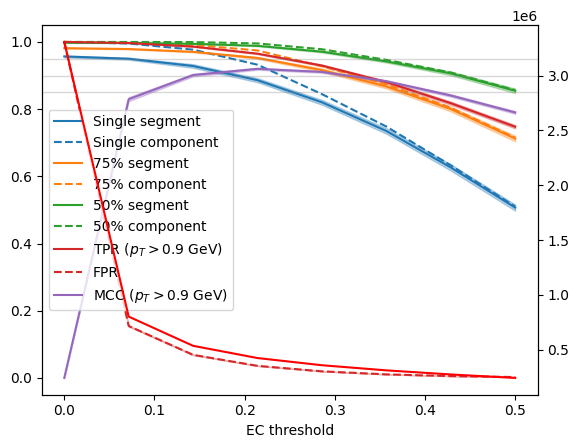

In [34]:
ttip.plot()
ax2 = ttip.ax.twinx()
ax2.plot(df["threshold"], df["n_predicted_true"], color="red")

In [19]:
df["n_edges"] = df["n_true"] + df["n_false"]

In [22]:
ax2.get_figure().show()